In [27]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
from jaratoolbox import loadopenephys
from jaratoolbox import spikesorting
from jaratoolbox.test.nick import clustercutting
from matplotlib import pyplot as plt
import os
import numpy as np

## Loading spikes

In [4]:
animalName='pinp013'
ephysLoc = '/home/nick/data/ephys/'
ephysPath = os.path.join(ephysLoc, animalName)
ephysFn='2016-05-27_14-13-26'
tetrode=3
spikesFn = os.path.join(ephysPath, ephysFn, 'Tetrode{}.spikes'.format(tetrode))
dataSpikes = loadopenephys.DataSpikes(spikesFn)

In [5]:
GAIN = 5000.0
SAMPLING_RATE=30000.0
dataSpikes.samples = ((dataSpikes.samples - 32768.0) / GAIN) * 1000.0
dataSpikes.timestamps = dataSpikes.timestamps/SAMPLING_RATE

(numSpikes, numChans, numSamples) = shape(dataSpikes.samples)

allWaves = dataSpikes.samples.reshape(numSpikes, numChans*numSamples)

## Embedding spikes in 2D with t-SNE

In [10]:
from sklearn.manifold import TSNE

In [11]:
import timeit
start_time = timeit.default_timer()

model = TSNE(n_components=2, method='barnes_hut', verbose=20, n_iter=1000)
Y = model.fit_transform(allWaves)

elapsed = timeit.default_timer() - start_time
print 'ELAPSED TIME: {} mins'.format(elapsed/60)


[t-SNE] Iteration 275: error difference 0.000000. Finished.
[t-SNE] Error after 275 iterations: 1.308920
ELAPSED TIME: 2.5559571147 mins

[t-SNE] Iteration 275: error = 1.2797867, gradient norm = 0.0013074
[t-SNE] Iteration 250: error = 1.2797965, gradient norm = 0.0013076
[t-SNE] Iteration 225: error = 1.2798309, gradient norm = 0.0013081
[t-SNE] Iteration 200: error = 1.2799513, gradient norm = 0.0013102
[t-SNE] Iteration 175: error = 1.2803946, gradient norm = 0.0013181
[t-SNE] Iteration 150: error = 1.2820615, gradient norm = 0.0013488
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.308920
[t-SNE] Iteration 125: error = 1.2886382, gradient norm = 0.0014932
[t-SNE] Iteration 100: error = 1.3089199, gradient norm = 0.0021201
[t-SNE] Iteration 75: error = 1.3118362, gradient norm = 0.0022460
[t-SNE] Iteration 25: gradient norm 0.000787. Finished.
[t-SNE] Iteration 50: error = 1.3255427, gradient norm = 0.0030091
[t-SNE] Computed conditional probabilities for sam

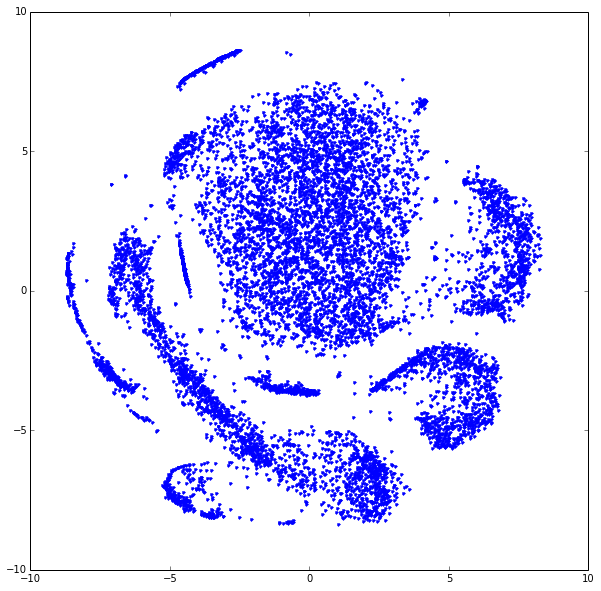

In [21]:
figure(figsize=(10, 10))
plot(Y[:,0], Y[:,1], '.')

## Clustering with HDBSCAN

In [15]:
import hdbscan

/usr/lib/python2.7/dist-packages/pkg_resources.py:1031: UserWarning: /home/nick/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [16]:
clus = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clus.fit_predict(Y)

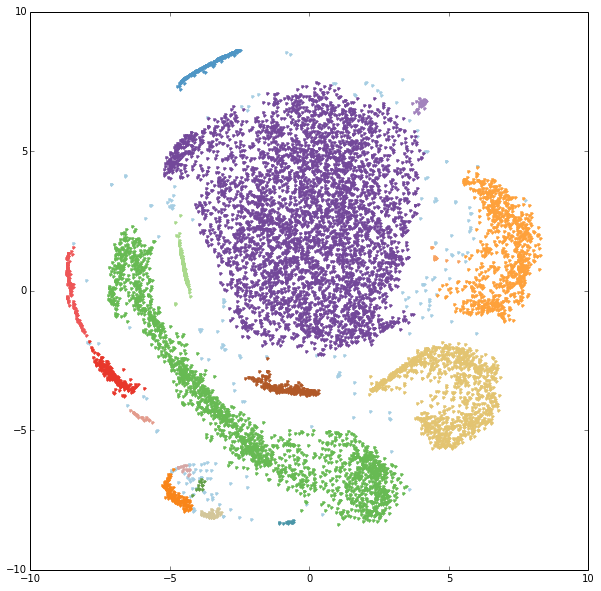

In [20]:
figure(figsize=(10, 10))
uniqueLabels = np.unique(cluster_labels)
colors = plt.cm.Paired(np.linspace(0, 1, len(uniqueLabels)))
for indLabel, label in enumerate(unique(cluster_labels)):
    hold(1)
    indsThisLabel = np.flatnonzero(cluster_labels==label)
    plot(Y[indsThisLabel, 0], Y[indsThisLabel, 1], '.', color=colors[indLabel])

## Plotting cluster waveforms

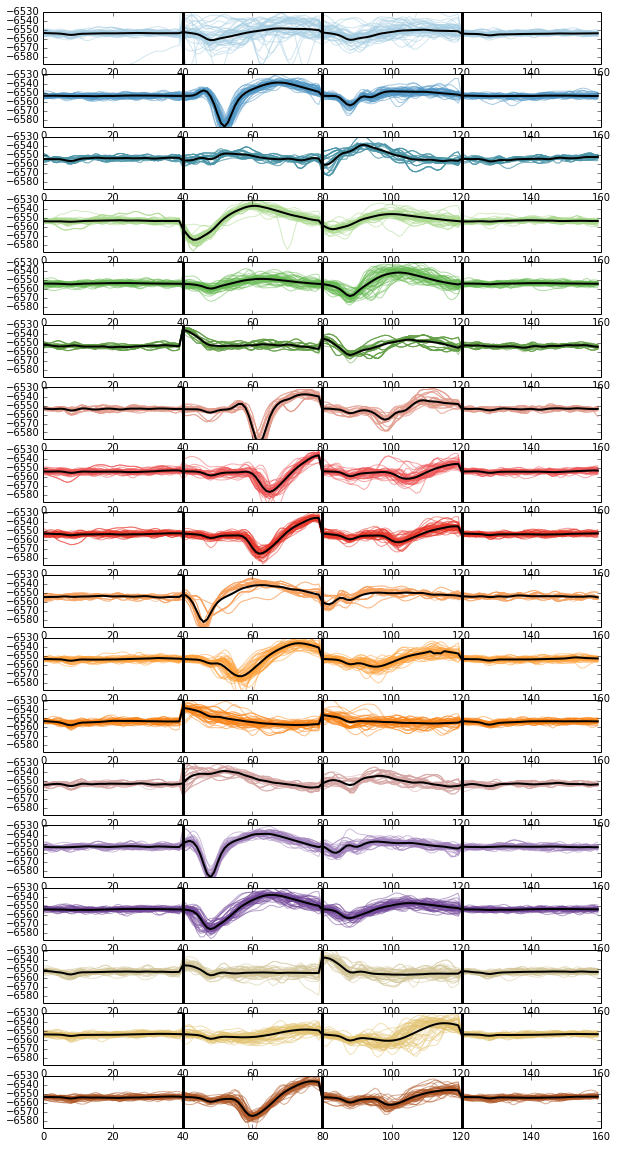

In [19]:
figure(figsize=(10, 20))
labels = cluster_labels
rav = allWaves.ravel()
maxv = percentile(rav, 99.95)
minv = percentile(rav, 0.05)
for indLabel, label in enumerate(uniqueLabels):
    subplot(len(uniqueLabels), 1, indLabel+1)
    clusterWaves = allWaves[labels==label]

    spikesToPlot = np.random.randint(len(clusterWaves),size=50)

    for wave in clusterWaves[spikesToPlot]:
        plot(wave, '-', alpha=0.5, color=colors[indLabel])
        hold(1)
    plot(clusterWaves.mean(0), 'k', lw=2, zorder=10)
    ylim([minv, maxv])
    axvline(x=40, lw=3, color='k')
    axvline(x=80, lw=3, color='k')
    axvline(x=120, lw=3, color='k')


## Determining memory usage for different number of spikes and type of data

In [12]:
# The data are stored by openephys as unsigned int16s
#In the earlier example, I first converted the spikes to microvolts (doubles)
#I want to see if the tSNE algo is faster on the int16s or the doubles
dataSpikes = loadopenephys.DataSpikes(spikesFn)
dataSpikes.samples
(numSpikes, numChans, numSamples) = np.shape(dataSpikes.samples)
allWaves = dataSpikes.samples.reshape(numSpikes, numChans*numSamples)

In [13]:
# Select a number of spikes randomly
spikesToUse = np.random.randint(len(dataSpikes.samples),size=50)
wavesToUse = allWaves[spikesToUse, :]

In [2]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [16]:
from sklearn.manifold import TSNE

In [21]:
%%memit 
spikesToUse = np.random.randint(len(dataSpikes.samples),size=50)
wavesToUse = allWaves[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)


peak memory: 113.46 MiB, increment: 0.00 MiB


In [22]:
%%memit 
spikesToUse = np.random.randint(len(dataSpikes.samples),size=500)
wavesToUse = allWaves[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)

peak memory: 113.47 MiB, increment: 0.00 MiB


In [25]:
%%memit 
spikesToUse = np.random.randint(len(dataSpikes.samples),size=1000)
wavesToUse = allWaves[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)

peak memory: 115.64 MiB, increment: 33.38 MiB


In [32]:
%%memit 
spikesToUse = np.random.randint(len(dataSpikes.samples),size=2500)
wavesToUse = allWaves[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)

peak memory: 260.74 MiB, increment: 142.89 MiB


In [23]:
%%memit 
spikesToUse = np.random.randint(len(dataSpikes.samples),size=5000)
wavesToUse = allWaves[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)

peak memory: 873.90 MiB, increment: 760.43 MiB


In [24]:
%%memit 
spikesToUse = np.random.randint(len(dataSpikes.samples),size=10000)
wavesToUse = allWaves[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)

peak memory: 3456.89 MiB, increment: 3336.08 MiB


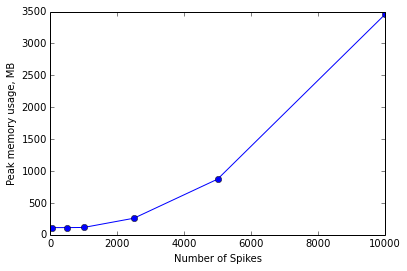

In [34]:
numSpikes = [50, 500, 1000, 2500, 5000, 10000]
memUsed = [113, 113, 115, 260, 873, 3456]
plot(numSpikes, memUsed, '-o')
ylabel('Peak memory usage, MB')
xlabel('Number of Spikes')

In [35]:
# Doesn't look real linear, but if we assume that the memory used by
# tSNE really does scale linearly with the size of the input we shoudl use the 
# last 2 points 
dx = 10000-5000.0
dy = 3656-873.0
m = dy/dx

In [40]:
b = -10000*m + 3656

In [41]:
b

-1910.0

In [42]:
m* 10000 + b

3656.0

In [43]:
m * 5000 + b

873.0

In [44]:
animalName='adap020'
ephysLoc = '/home/nick/data/ephys/'
ephysPath = os.path.join(ephysLoc, animalName)
ephysFn='2016-05-25_16-33-09'
tetrode=2
spikesFn = os.path.join(ephysPath, ephysFn, 'Tetrode{}.spikes'.format(tetrode))
dataSpikes = loadopenephys.DataSpikes(spikesFn)

In [47]:
bigSpikeNum = len(dataSpikes.samples)

In [50]:
memNeeded = m * bigSpikeNum + b

In [51]:
memNeeded/1000
# This is a big number, 620 Gb

620.3287247999999

## Reducing dimensionality with PCA before tSNE

The creator of t-SNE recommends reducing number of dimensions to ~50 if number of samples is high. 

In [52]:
from matplotlib.mlab import PCA

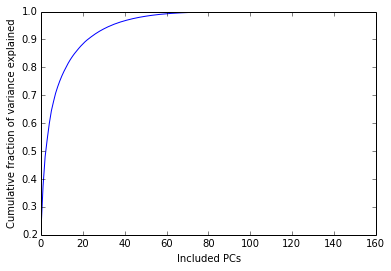

In [60]:
# Run PCA on the allWaves variable from above and then re-calculate t-SNE with
# diff numbers of spikes

results = PCA(allWaves)
plot(cumsum(results.fracs))
ylabel('Cumulative fraction of variance explained')
xlabel('Included PCs')

We can see that almost all of the variance is explained by the first 50 PCs

In [65]:
%%memit 
first50 = results.Y[:, 0:50]
spikesToUse = np.random.randint(len(first50),size=1000)
wavesToUse = first50[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)

peak memory: 604.39 MiB, increment: 0.00 MiB


In [66]:
%%memit 
first50 = results.Y[:, 0:20]
spikesToUse = np.random.randint(len(first50),size=1000)
wavesToUse = first50[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)

peak memory: 604.40 MiB, increment: 0.01 MiB


In [67]:
%%timeit
first50 = results.Y[:, 0:50]
spikesToUse = np.random.randint(len(first50),size=1000)
wavesToUse = first50[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)

1 loops, best of 3: 4.52 s per loop


In [68]:
%%timeit
first50 = results.Y[:, 0:20]
spikesToUse = np.random.randint(len(first50),size=1000)
wavesToUse = first50[spikesToUse, :]
model = TSNE(n_components=2, method='barnes_hut', verbose=0, n_iter=1000)
Y = model.fit_transform(wavesToUse)

1 loops, best of 3: 4.5 s per loop


It does not really look like reducing the number of dimensions changes the time it takes to run this small input. Lets run the whole set and see if it seems faster.

In [70]:
import timeit
start_time = timeit.default_timer()
first50 = results.Y[:, 0:50]
model = TSNE(n_components=2, method='barnes_hut', verbose=20, n_iter=1000)
Y = model.fit_transform(first50)
elapsed = timeit.default_timer() - start_time
print 'ELAPSED TIME: {} mins'.format(elapsed/60)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10111
[t-SNE] Computed conditional probabilities for sample 2000 / 10111
[t-SNE] Computed conditional probabilities for sample 3000 / 10111
[t-SNE] Computed conditional probabilities for sample 4000 / 10111
[t-SNE] Computed conditional probabilities for sample 5000 / 10111
[t-SNE] Computed conditional probabilities for sample 6000 / 10111
[t-SNE] Computed conditional probabilities for sample 7000 / 10111
[t-SNE] Computed conditional probabilities for sample 8000 / 10111
[t-SNE] Computed conditional probabilities for sample 9000 / 10111
[t-SNE] Computed conditional probabilities for sample 10000 / 10111
[t-SNE] Computed conditional probabilities for sample 10111 / 10111
[t-SNE] Mean sigma: 2.347829
[t-SNE] Iteration 25: error = 1.3191513, gradient norm = 0.0004579
[t-SNE] Iteration 25: gradient norm 0.000458. Finished.
[t-SNE] Iteration 50: error

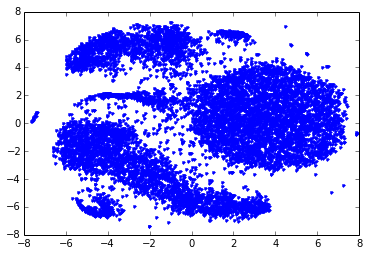

In [72]:
plot(Y[:,0], Y[:,1], '.')

2.3 mins is faster than the whole dataset was taking to run before.

In [78]:
clus = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clus.fit_predict(Y)

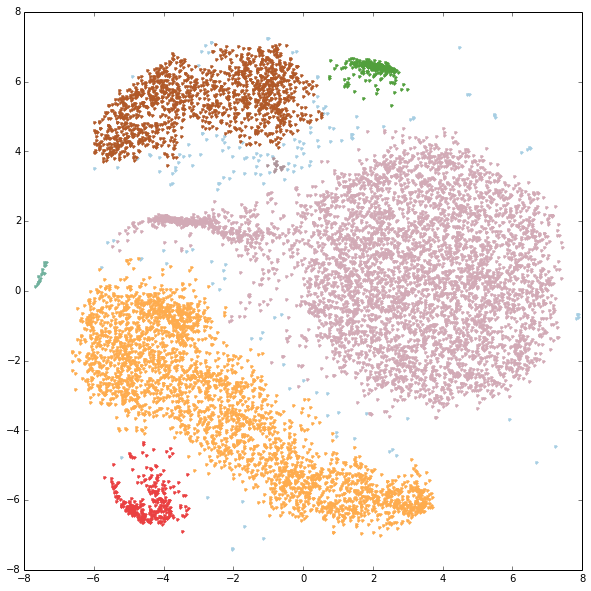

In [79]:
figure(figsize=(10, 10))
uniqueLabels = np.unique(cluster_labels)
colors = plt.cm.Paired(np.linspace(0, 1, len(uniqueLabels)))
for indLabel, label in enumerate(unique(cluster_labels)):
    hold(1)
    indsThisLabel = np.flatnonzero(cluster_labels==label)
    plot(Y[indsThisLabel, 0], Y[indsThisLabel, 1], '.', color=colors[indLabel])

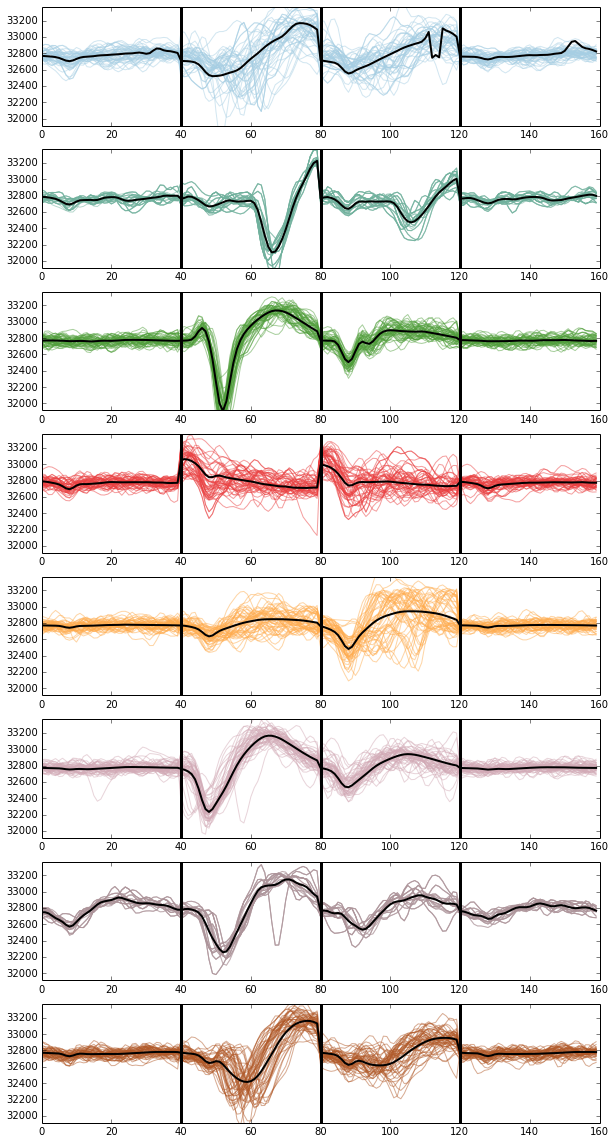

In [80]:
figure(figsize=(10, 20))
labels = cluster_labels
rav = allWaves.ravel()
maxv = percentile(rav, 99.95)
minv = percentile(rav, 0.05)
for indLabel, label in enumerate(uniqueLabels):
    subplot(len(uniqueLabels), 1, indLabel+1)
    clusterWaves = allWaves[labels==label]

    spikesToPlot = np.random.randint(len(clusterWaves),size=50)

    for wave in clusterWaves[spikesToPlot]:
        plot(wave, '-', alpha=0.5, color=colors[indLabel])
        hold(1)
    plot(clusterWaves.mean(0), 'k', lw=2, zorder=10)
    ylim([minv, maxv])
    axvline(x=40, lw=3, color='k')
    axvline(x=80, lw=3, color='k')
    axvline(x=120, lw=3, color='k')